# Deprecated code suggestions

```{seealso}
Download the notebook: {nb-download}`deprecated.ipynb`
```

| **Target** | **Depr** | **Remv** | **Alternatives** |
|---|---|---|---|
| `ScheduleGettable.generate_diagnostics_report()` | 0.17 | 0.18 | See {ref}`ScheduleGettable.generate_diagnostics_report()` |
| `plot_kwargs` parameter in `ScheduleBase.plot_pulse_diagram()` | 0.15 | - | See {ref}`plot_kwargs parameter in ScheduleBase.plot_pulse_diagram()` |
| `repetitions` parameter in `ScheduleGettable.process_acquired_data()` | 0.15 | 0.18 | See {ref}`repetitions parameter in ScheduleGettable.process_acquired_data()` |
| `t` parameter in `NumericalWeightedIntegrationComplex` | 0.13 | 0.18 | See {ref}`t parameter in NumericalWeightedIntegrationComplex` |
| Qblox `convert_hw_config_to_portclock_configs_spec()` | 0.13 | 0.18 | See {ref}`Qblox Hardware Configuration` |
| Qblox `instruction_generated_pulses_enabled` hardware config setting | 0.13 | 0.17 | See {ref}`Instruction-generated pulses (Qblox only)` |
| `quantify_scheduler.visualization` | 0.12 | 0.15 | See {ref}`Circuit diagrams and pulse diagrams` |
| `acq_channel` (in {class}`~quantify_scheduler.operations.gate_library.Measure` and {class}`~quantify_scheduler.operations.nv_native_library.CRCount`) | 0.10 | 0.13 | See {ref}`acq_channel` |
| `quantify_scheduler.compilation.qcompile()`<br>`quantify_scheduler.compilation.device_compile()`<br>`quantify_scheduler.compilation.hardware_compile()` | 0.10 | 0.13 | See {ref}`qcompile() => SerialCompiler` |
| The `data` parameter in `Operation` subclasses | 0.9 | 0.15 | - |
| Old Qblox hardware configuration | 0.8 | 0.13 | See {ref}`Qblox Hardware Configuration` |
| `TransmonElement` | 0.7 | 0.13 | See {ref}`TransmonElement => BasicTransmonElement` |
| `add_pulse_information_transmon()` | 0.6 | 0.13 | See {ref}`add_pulse_information_transmon() => compile_circuit_to_device()` |
| `plot_circuit_diagram_mpl()` | 0.6 | 0.9 | {meth}`~quantify_scheduler.schedules.schedule.ScheduleBase.plot_circuit_diagram` |
| `plot_pulse_diagram_mpl()` | 0.6 | 0.9 | {meth}`~quantify_scheduler.schedules.schedule.ScheduleBase.plot_pulse_diagram` |

As of `quantify-scheduler==0.10.0`, deprecation warnings are shown by default (as `FutureWarning`).

## Compilation Setup

In [1]:
from quantify_core.data import handling as dh
from quantify_core.measurement.control import MeasurementControl
from quantify_scheduler.instrument_coordinator import InstrumentCoordinator
from quantify_scheduler.instrument_coordinator.components.qblox import ClusterComponent

from qblox_instruments import Cluster, ClusterType
from qcodes import Instrument

dh.set_datadir(dh.default_datadir())

Instrument.close_all()
meas_ctrl = MeasurementControl("meas_ctrl")
ic = InstrumentCoordinator("ic")

cluster = Cluster(
    "cluster",
    dummy_cfg={
        1: ClusterType.CLUSTER_QRM_RF,
    },
)

ic_cluster = ClusterComponent(cluster)
ic.add_component(ic_cluster)

# Always picks the first module of a certain type, and ignores the others of same type!
qcm_rf, qrm_rf, qcm, qrm = [None] * 4
for module in cluster.modules:
    try:
        if module.is_rf_type:
            if module.is_qcm_type:
                if qcm_rf is None:
                    qcm_rf = module
            else:
                if qrm_rf is None:
                    qrm_rf = module
        else:
            if module.is_qcm_type:
                if qcm is None:
                    qcm = module
            else:
                if qrm is None:
                    qrm = module
    except KeyError:
        continue

print(f"qcm    => {qcm}\nqrm    => {qrm}\nqcm_rf => {qcm_rf}\nqrm_rf => {qrm_rf}")

Data will be saved in:
/root/quantify-data


qcm    => None
qrm    => None
qcm_rf => None
qrm_rf => <Module: cluster_module1 of Cluster: cluster>


In [2]:
from quantify_scheduler.device_under_test.quantum_device import QuantumDevice
from quantify_scheduler.device_under_test.transmon_element import BasicTransmonElement

q0 = BasicTransmonElement("q0")

quantum_device = QuantumDevice("quantum_device")
quantum_device.add_element(q0)
quantum_device.instr_measurement_control(meas_ctrl.name)
quantum_device.instr_instrument_coordinator(ic.name)

q0.clock_freqs.f01(7.3e9)
q0.clock_freqs.f12(7.0e9)
q0.clock_freqs.readout(8.2e9)
q0.measure.acq_delay(100e-9)
q0.measure.acq_channel(0)
q0.measure.pulse_amp(0.2)

device_cfg = quantum_device.generate_device_config()

In [3]:
hardware_cfg = {
    "backend": "quantify_scheduler.backends.qblox_backend.hardware_compile",
    "cluster": {
        "ref": "internal",
        "instrument_type": "Cluster",
        f"cluster_module{qrm_rf.slot_idx}": {
            "instrument_type": "QRM_RF",
            "complex_output_0": {
                "lo_freq": 2e9,
                "portclock_configs": [
                    {
                        "port": "q0:res",
                        "clock": "q0.ro",
                    },
                ],
            },
        },
    },
}

In [4]:
from quantify_scheduler import Schedule
from quantify_scheduler.operations.gate_library import Measure, Reset
from quantify_scheduler.operations.pulse_library import DRAGPulse
from quantify_scheduler.resources import ClockResource


def simple_trace_sched(
    repetitions: int,
    pulse_amp: float = 0.2, 
) -> Schedule:
    sched = Schedule("Simple trace schedule", repetitions)

    port = "q0:res"
    clock = "q0.ro"

    sched.add(Reset("q0"))
    sched.add(Measure("q0", acq_index=0, acq_protocol="Trace"))
    sched.add(
        DRAGPulse(
            G_amp=pulse_amp,
            D_amp=0,
            phase=0,
            duration=160e-9,
            port=port,
            clock=clock,
        )
    )

    return sched


sched = simple_trace_sched(repetitions=1)

## qcompile() => SerialCompiler

The `qcompile()`, `device_compile()` and `hardware_compile()` compilation functions have been replaced by the {class}`~quantify_scheduler.backends.graph_compilation.SerialCompiler`. For step-by-step guides on how to perform compilation to the device level and hardware, please see {ref}`Compiling to Hardware<sec-tutorial-compiling>` and {ref}`Operations and Qubits<sec-tutorial-ops-qubits>`. A brief example is shown below.

First, run {ref}`Compilation Setup`.

In [5]:
# Old way:
# from quantify_scheduler.compilation import qcompile

# compiled_schedule = qcompile(sched, device_cfg, hardware_cfg)

In [6]:
from quantify_scheduler.backends.graph_compilation import SerialCompiler

quantum_device.hardware_config(hardware_cfg)

compiler = SerialCompiler(name="compiler")
compiled_schedule = compiler.compile(
    schedule=sched, config=quantum_device.generate_compilation_config()
)

In [7]:
compiled_schedule.timing_table

## ScheduleGettable.generate_diagnostics_report()

In version 0.17, the `ScheduleGettable.generate_diagnostics_report` method received a major update. This method should no longer be called directly. Instead, the experiment should be run via the {meth}`.ScheduleGettable.initialize_and_get_with_report` method, which executes the experiment and generates a diagnostics report for debugging.

## plot_kwargs parameter in ScheduleBase.plot_pulse_diagram()

In version 0.15, the `plot_kwargs` parameter of the {meth}`.ScheduleBase.plot_pulse_diagram` method was replaced by variable keyword arguments (`**kwargs`). This means that the dictionary provided to `plot_kwargs` can be unpacked and passed to the method directly. For example,

```python
schedule.plot_pulse_diagram(plot_kwargs={"x_range": (201e-6, 201.5e-6)})
```

can now be written as

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Simple trace schedule'}, xlabel='Time [ns]', ylabel='Amplitude [mV]'>)

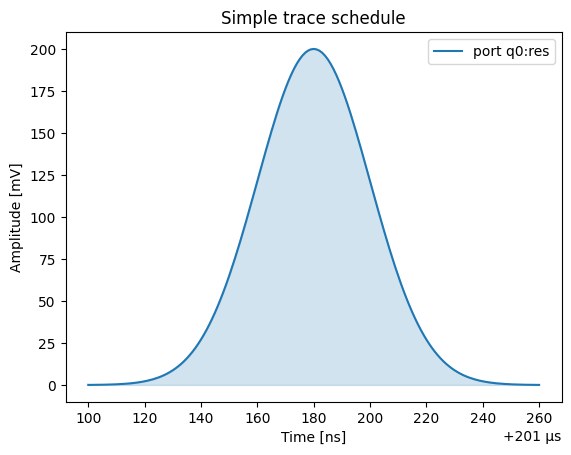

In [8]:
compiled_schedule.plot_pulse_diagram(x_range=(201e-6, 201.5e-6))

## repetitions parameter in ScheduleGettable.process_acquired_data()

In version 0.15, the `repetitions` parameter of the {meth}`.ScheduleGettable.process_acquired_data` method was deprecated. This parameter has no effect, and can simply be omitted. The {ref}`sec-tutorial-schedulegettable-repetitions` section of {ref}`sec-tutorial-schedulegettable` contains more information on how to set the number of repetitions in an experiment.

## t parameter in NumericalWeightedIntegrationComplex

In version 0.13.0, the `t` parameter in the {class}`~quantify_scheduler.operations.acquisition_library.NumericalWeightedIntegrationComplex` initializer was replaced by the `weights_sampling_rate` parameter, which takes a sampling rate in Hz.

This means that creating a class instance as

```python
NumericalWeightedIntegrationComplex(
    weights_a=[0.1, 0.2, 0.3],
    weight_b=[0.4, 0.5, 0.6],
    t=[0.0, 1e-9, 2e-9],
    port="some_port",
    clock="some_clock",
    # other args
)
```

should now be done as

In [9]:
from quantify_scheduler.operations.acquisition_library import NumericalWeightedIntegrationComplex


NumericalWeightedIntegrationComplex(
    weights_a=[0.1, 0.2, 0.3],
    weights_b=[0.4, 0.5, 0.6],
    weights_sampling_rate=1e9,
    port="some_port",
    clock="some_clock",
    # other args
)

/usr/local/lib/python3.9/site-packages/quantify_scheduler/operations/acquisition_library.py:581: FutureWarning: NumericalWeightedIntegrationComplex is deprecated and will be removed in quantify-scheduler>=0.20.0. Use NumericalSeparatedWeightedIntegration instead.
  warnings.warn(


NumericalSeparatedWeightedIntegration(weights_a=[0.1, 0.2, 0.3], weights_b=[0.4, 0.5, 0.6], weights_sampling_rate=999999999.9999999, port='some_port', clock='some_clock', interpolation='linear', acq_channel=0, acq_index=0, bin_mode='append', phase=0, t0=0)

## Circuit diagrams and pulse diagrams

The functions to plot circuit and pulse diagrams have moved to a private module in version 0.12.0.

Instead, to plot circuit and pulse diagrams, call, directly on the schedule,  {meth}`~quantify_scheduler.schedules.schedule.ScheduleBase.plot_circuit_diagram` and {meth}`~quantify_scheduler.schedules.schedule.ScheduleBase.plot_pulse_diagram`. 

For example, the line

```python
pulse_diagram_plotly(schedule)
pulse_diagram_matplotlib(schedule)
```

should now be written as

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Simple trace schedule'}, xlabel='Time [μs]', ylabel='Amplitude [mV]'>)

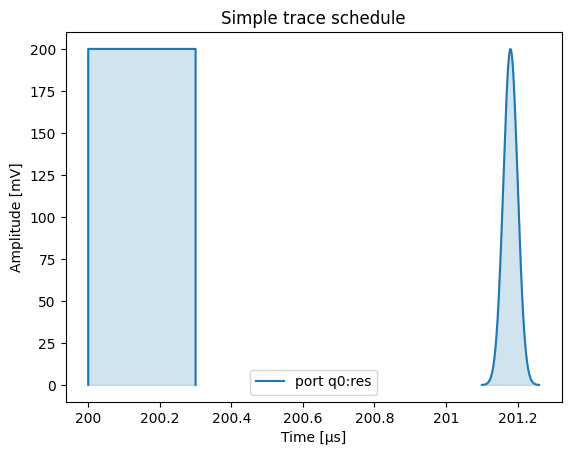

In [10]:
compiled_schedule.plot_pulse_diagram(plot_backend="plotly")
compiled_schedule.plot_pulse_diagram(plot_backend="mpl")

More examples can be found in the {ref}`Schedules and Pulses<sec-tutorial-sched-pulse>` and {ref}`Operations and Qubits<sec-tutorial-ops-qubits-vis>` tutorials.

## acq_channel

In the {class}`~quantify_scheduler.operations.gate_library.Measure` and {class}`~quantify_scheduler.operations.nv_native_library.CRCount` classes, the `acq_channel` parameter has been removed from the initializers. For gate-level operations, the acquisition channel can be set in the {class}`~quantify_scheduler.device_under_test.device_element.DeviceElement` subclasses, such as {class}`~quantify_scheduler.device_under_test.transmon_element.BasicTransmonElement`, instead. See, for example, `q0.measure.acq_channel(0)` in the {ref}`Compilation Setup`.



## add_pulse_information_transmon() => compile_circuit_to_device()

The compilation step `add_pulse_information_transmon` has been replaced by `compile_circuit_to_device`. For steps on how to add device configuration to your compilation steps, please see {ref}`Operations and Qubits<sec-tutorial-ops-qubits>`.

## Qblox Hardware Configuration

In quantify-scheduler 0.8.0, the schema for the Qblox hardware configuration was revised. From version 0.13.0, old hardware configurations will no longer be automatically converted. Below is a summary of the changes.

1. `seqx` => `portclock_configs`  
1. `latency_correction` => standalone/top-level `latency_corrections`
1. `line_gain_db` removed

```{warning}
The helper function `convert_hw_config_to_portclock_configs_spec` has been removed in version 0.18.0.
```

In [11]:
depr_hardware_cfg = {
    "backend": "quantify_scheduler.backends.qblox_backend.hardware_compile",
    "cluster": {
        "ref": "internal",
        "instrument_type": "Cluster",
        "cluster_module1": {
            "instrument_type": "QRM_RF",
            "complex_output_0": {
                "line_gain_db": 0,
                "seq0": {
                    "port": "q6:res",
                    "clock": "q6.ro",
                    "latency_correction": 4e-9,
                },
                "seq1": {
                    "port": "q1:res",
                    "clock": "q1.ro",
                },
            },
        },
    },
}

In [12]:
correct_hardware_cfg = {
    "backend": "quantify_scheduler.backends.qblox_backend.hardware_compile",
    "cluster": {
        "ref": "internal",
        "instrument_type": "Cluster",
        "cluster_module1": {
            "instrument_type": "QRM_RF",
            "complex_output_0": {
                "portclock_configs": [
                    {
                        "port": "q6:res",
                        "clock": "q6.ro"
                    },
                    {
                        "port": "q1:res",
                        "clock": "q1.ro"
                    }
                ]
            }
        }
    },
    "latency_corrections": {
        "q6:res-q6.ro": 4e-09
    }
}

## TransmonElement => BasicTransmonElement

In quantify-scheduler 0.7.0, the {class}`~quantify_scheduler.device_under_test.transmon_element.BasicTransmonElement` class was added and replaced the `TransmonElement` class.

In [13]:
from qcodes import Instrument

Instrument.close_all()

In [14]:
# Before:
# from quantify_scheduler.device_under_test.transmon_element import TransmonElement

# transmon = TransmonElement("transmon")
# print(f"{transmon.name}: {list(transmon.parameters.keys())}")

# After:
from quantify_scheduler.device_under_test.transmon_element import BasicTransmonElement

basic = BasicTransmonElement("basic")
print(f"{basic.name}: {list(basic.parameters.keys()) + list(basic.submodules.keys())}")
for submodule_name, submodule in basic.submodules.items():
    print(f"{basic.name}.{submodule_name}: {list(submodule.parameters.keys())}")

basic: ['IDN', 'reset', 'rxy', 'measure', 'ports', 'clock_freqs']
basic.reset: ['duration']
basic.rxy: ['amp180', 'motzoi', 'duration']
basic.measure: ['pulse_type', 'pulse_amp', 'pulse_duration', 'acq_channel', 'acq_delay', 'integration_time', 'reset_clock_phase', 'acq_weights_a', 'acq_weights_b', 'acq_weights_sampling_rate', 'acq_weight_type', 'acq_rotation', 'acq_threshold']
basic.ports: ['microwave', 'flux', 'readout']
basic.clock_freqs: ['f01', 'f12', 'readout']


The block below shows how the attributes of the `TransmonElement` (`transmon`) are converted to attributes of the `BasicTransmonElement` (`basic`).

```
transmon.IDN                                         =>    basic.IDN
transmon.instrument_coordinator                      =>    None
transmon.init_duration                               =>    basic.reset.duration
transmon.mw_amp180                                   =>    basic.rxy.amp180
transmon.mw_motzoi                                   =>    basic.rxy.motzoi
transmon.mw_pulse_duration                           =>    basic.rxy.duration
transmon.mw_ef_amp180                                =>    None
transmon.mw_port                                     =>    basic.ports.microwave
transmon.fl_port                                     =>    basic.ports.flux
transmon.ro_port                                     =>    basic.ports.readout
transmon.mw_01_clock                                 =>    no longer settable, always "basic.01"
transmon.mw_12_clock                                 =>    no longer settable, always "basic.12"
transmon.ro_clock                                    =>    no longer settable, always "basic.ro"
transmon.freq_01                                     =>    basic.clock_freqs.f01
transmon.freq_12                                     =>    basic.clock_freqs.f12
transmon.ro_freq                                     =>    basic.clock_freqs.readout
transmon.ro_pulse_amp                                =>    basic.measure.pulse_amp
transmon.ro_pulse_duration                           =>    basic.measure.pulse_duration
transmon.ro_pulse_type                               =>    basic.measure.pulse_type
transmon.ro_pulse_delay                              =>    via:	schedule.add(..., rel_time=...)
transmon.ro_acq_channel                              =>    basic.measure.acq_channel
transmon.ro_acq_delay                                =>    basic.measure.acq_delay
transmon.ro_acq_integration_time                     =>    basic.measure.integration_time
transmon.spec_pulse_duration                         =>    via:	schedule.add(SpectroscopyOperation("basic")), not implemented for BasicTransmonElement, see BasicElectronicNVElement.spectroscopy_operation
transmon.spec_pulse_frequency                        =>    via:	schedule.add(SpectroscopyOperation("basic")), not implemented for BasicTransmonElement, see BasicElectronicNVElement.spectroscopy_operation
transmon.spec_pulse_amp                              =>    via:	schedule.add(SpectroscopyOperation("basic")), not implemented for BasicTransmonElement, see BasicElectronicNVElement.spectroscopy_operation
transmon.spec_pulse_clock                            =>    via:	schedule.add(SpectroscopyOperation("basic")), not implemented for BasicTransmonElement, see BasicElectronicNVElement.spectroscopy_operation
transmon.acquisition                                 =>    via:	schedule.add(Measure("basic", acq_protocol=...))
transmon.ro_acq_weight_type                          =>    basic.measure.acq_weight_type
schedule.add(Measure("transmon", acq_channel=...))   =>    basic.measure.acq_channel
```

Both classes will generate the same device configuration.

In [15]:
import pprint

# device_config_transmon = transmon.generate_device_config().model_dump()
# pprint.pprint(device_config_transmon)

device_config_basic_transmon = basic.generate_device_config().model_dump()
pprint.pprint(device_config_basic_transmon)

{'clocks': {'basic.01': nan, 'basic.12': nan, 'basic.ro': nan},
 'compilation_passes': [{'compilation_func': 'quantify_scheduler.backends.circuit_to_device.compile_circuit_to_device_with_config_validation',
                         'name': 'circuit_to_device'},
                        {'compilation_func': 'quantify_scheduler.backends.circuit_to_device.set_pulse_and_acquisition_clock',
                         'name': 'set_pulse_and_acquisition_clock'},
                        {'compilation_func': 'quantify_scheduler.compilation.resolve_control_flow',
                         'name': 'resolve_control_flow'},
                        {'compilation_func': 'quantify_scheduler.compilation._determine_absolute_timing',
                         'name': 'determine_absolute_timing'},
                        {'compilation_func': 'quantify_scheduler.compilation.flatten_schedule',
                         'name': 'flatten'}],
 'edges': {},
 'elements': {'basic': {'H': {'factory_func': 'quantify_sche

## Instruction-generated pulses (Qblox only)

Instead of using the ``instruction_generated_pulses_enabled: True`` field in the port-clock configuration for generating long square and staircase pulses, you can now create long square, staircase and ramp waveforms (that would otherwise not fit in memory), by creating these operations with the following helper functions.

In [16]:
from quantify_scheduler.backends.qblox.operations import (
    long_ramp_pulse,
    long_square_pulse,
    staircase_pulse,
)

ramp_pulse = long_ramp_pulse(amp=0.5, duration=1e-3, port="q0:mw")
square_pulse = long_square_pulse(amp=0.5, duration=1e-3, port="q0:mw")
staircase_pulse = staircase_pulse(
    start_amp=0.0, final_amp=1.0, num_steps=20, duration=1e-4, port="q0:mw"
)

More complex long waveforms can now also be created, see section {ref}`Long waveform support <sec-long-waveforms-via-stitchedpulse>`.